# Indíce

- [Funções](#functions)
- [Load cashflows anuais](#loadcfs)
- [Simulação de cálculo de durations, impacto por taxas de desconto e outros parâmetros](#sims1)
- [Extração de dados da esperança média de vida aos 65 anos em Portugal, a partir do Eurostat e posterior cálculo da taxa de longevidade](#longevity)
- [Load IR STR e Credit Spread yields](#loadircs)
- [Resultados de simulações de Impactos e cálculo de VaR](#var_results)
- [Impactos com stress de IPC](#ipc_impacts)
- [Experimentações](#exp)

# Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from ecbdata import ecbdata
from pyjstat import pyjstat

# data viz libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.graph_objects as go
import plotly.express as px

# data processing and modeling libraries
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
import statsmodels.api as sm

from IPython.display import display, HTML
import os

import warnings
warnings.filterwarnings("ignore")

# gvm library
import obiwan as obi

# default nb colors for plots
default_color = '#BFCE28'
default_color2 = '#179297'

username = os.getenv('USERNAME_COLABORADOR')

# Funções <a name='functions'></a>

In [2]:
def df_cashflows_with_earlystop_discount(df, year_early_stop=45):

    """
    Params: - pandas DataFrame with liabilities cashflows 'resp_b_NB_total' column by year
            - year_early_stop is the number of rows we want unmodified
            
    Returns: head(year_early_stop) of the same pandas DataFrame plus one more row which is the sum of the rest of the rows of original dataframe
    """
    
    df_aux = df
    df_aux['ano_aux'] = range(1, len(df) + 1)
    
    df_aux = df[df['ano_aux'] <= year_early_stop + 1]
    df_aux2 = df[df['ano_aux'] > year_early_stop]
    
    df_aux.loc[df_aux['ano_aux'] == year_early_stop + 1, 'resp_b_NB_total'] = df_aux2['resp_b_NB_total'].sum()
    
    return df_aux

# Não necessário para cálculo do VaR
def simulate_npv_duration_by_discount_rate(df, coluna_ano, coluna_resp, discount_rate):

    """
    Params: - pandas DataFrame with liabilities cashflows 'resp_b_NB_total' column by year (column)
            - year column name
            - liabilities column
            - discount rate value
            
    Returns: - pandas DataFrame with one more column with discounted liabilites by year taking the discount year into account
             - NPV = Sum of the discounted liabilities
             - Duration of the discounted liabilities
    """
    
    df = df[[coluna_ano, coluna_resp]]
    
    df['ano_aux'] = range(1, len(df) + 1)

    df['resp_d'] = df[coluna_resp] / (1 + discount_rate)**df['ano_aux']

    sum_npv = df['resp_d'].sum()
    df['prod_npv_anoaux'] = df['resp_d'] * df['ano_aux']

    duration = df['prod_npv_anoaux'].sum() / df['resp_d'].sum()

    return df.drop(columns=['prod_npv_anoaux']), sum_npv, duration


# Não necessário para cálculo do VaR
def simulate_npv_impact_by_stressed_discount_rate(df, coluna_ano, coluna_resp, base_rate, shock_rate, scaling, allocation_nb, allocation_nb2, longevity_rate):

    """
    Params: - pandas DataFrame with liabilities cashflows by year
            - year column name
            - liabilities column name
            - base rate
            - shock to apply to the base rate
            - scaling
            - allocation nb
            - allocation nb2
            - longevity rate

    Returns: - original pandas DataFrame df with 3 more columns, discounted liabilities at base_rate, discount liabilities with shocked discount and impact
             - NPV value considering base rate
             - NPV value considering shocked rate
             - Impact value (sum of the differences of the discounted liabilites and prior normalization using scaling, allocation a longevity constants) 
    """
    
    stressed_discount_rate = base_rate + shock_rate
    
    df = df[[coluna_ano, coluna_resp]].copy()
    
    df['ano_aux'] = range(1, len(df) + 1)
    
    base_col_name = 'resp_d' + str(round(base_rate * 100, 2))
    stressed_col_name = 'resp_d' + str(round(stressed_discount_rate * 100, 2))
    
    df[base_col_name] = df[coluna_resp] / (1 + base_rate) ** df['ano_aux']
    
    df[stressed_col_name] = (df[coluna_resp] * (1 + longevity_rate)) / (1 + stressed_discount_rate)** df['ano_aux']

    sum_npv_base_rate = int(df[base_col_name].sum().round())
    sum_npv_stressed_discount_rate = int(df[stressed_col_name].sum().round())
    
    df['impact'] = (df[stressed_col_name] - df[base_col_name]) * (1 + scaling) * (allocation_nb2 * allocation_nb)
    
    sum_impact = int(df['impact'].sum().round())
    
    return df, sum_npv_base_rate, sum_npv_stressed_discount_rate, sum_impact

**Funções necessárias para cálculo do VaR**

In [3]:
def calculate_npv(cashflows_df, longevity_rate, discount_rate):

    discount_rate = discount_rate/100
    
    cashflows_df['ano_aux'] = range(1, len(cashflows_df) + 1)

    cashflows_df['discounted_cashflow'] = (cashflows_df['resp_b_NB_total'] * (1 + longevity_rate))/ (1 + discount_rate)**cashflows_df['ano_aux']
    sum_npv = cashflows_df['discounted_cashflow'].sum()

    return sum_npv


def compute_impacts_var(yields_dataframe, cashflows_descontadas_dataframe, rate, longevity_rate, scaling, allocation_nb=1, allocation_nb2=1):
    
    df_final = yields_dataframe.copy()    

    df_final['stressed_rate'] = df_final['Return_total_260d'] + rate
    df_final['responsabilidades_diarias'] = df_final.apply(lambda row: calculate_npv(cashflows_descontadas_dataframe[['Ano', 'resp_b_NB_total']], longevity_rate, row['stressed_rate']), axis=1)
    
    df_final['impacto'] = (calculate_npv(cashflows_descontadas_dataframe, longevity_rate, rate) - df_final['responsabilidades_diarias']) * (1 + scaling) * (allocation_nb2 * allocation_nb)
    df_final['rank_impacto_IR_STR'] = df_final['impacto'].rank(method='min', ascending=True).astype(int)
    df_final['percentil'] = df_final['impacto'].rank(pct=True, ascending=True)

    #####
    df_final = df_final.sort_values(by='impacto')
    #####

    df_var = df_final[['Hist Date', 'Return_total_260d',
       'stressed_rate', 'responsabilidades_diarias', 'impacto']]

    var_999 = df_var['impacto'].quantile(0.001)
    var_min = df_var['impacto'].min()

    data_mais_proxima_999 = df_var[df_var['impacto'] <= var_999]['Hist Date'].values[-1]
    data_mais_proxima_min = df_var[df_var['impacto'] == var_min]['Hist Date'].values[0]
    
    print(f"O VaR_99.9 {int(var_999.round())} e a data correspondente é: {data_mais_proxima_999}")
    print(f"O VaR_min {int(var_min.round())} e a data correspondente é: {data_mais_proxima_min}")

    return df_var, var_999, var_min

**Funções para cálculo do NPV com stress de inflação**

In [4]:
def extract_max_annual_cpi(series_id, variable_name):
    series_id = 5721524
    variable_name = None

    df_cpi = obi.extract_data_from_bank_pt(series_id, variable_name)
    df_cpi = df_cpi[df_cpi['Date'] >= '2000-01-01']
    
    df_cpi['Year'] = df_cpi['Date'].dt.year
    
    annual_cpi_avg = df_cpi.groupby('Year')['CPI (inflation rate)-year on year rate'].mean().reset_index().round(1)

    cpi_rate = annual_cpi_avg['CPI (inflation rate)-year on year rate'].max()/100

    return cpi_rate

def calculate_npv_with_inflation(cashflows_df, longevity_rate, cpi_rate, discount_rate):

    discount_rate = discount_rate/100
    
    cashflows_df['ano_aux'] = range(1, len(cashflows_df) + 1)

    cashflows_df['discounted_cashflow'] = cashflows_df['resp_b_NB_total'] * (1 + cpi_rate) * (1 + longevity_rate) / (1 + discount_rate)**cashflows_df['ano_aux']
    sum_npv = cashflows_df['discounted_cashflow'].sum()

    return sum_npv


def compute_impacts_var_with_inflation(yields_dataframe, cashflows_descontadas_dataframe, rate, longevity_rate, scaling, allocation_nb=1, allocation_nb2=1):
    cpi_rate = extract_max_annual_cpi(5721524, None)
    
    df_final = yields_dataframe.copy()
    df_final['stressed_rate'] = df_final['Return_total_260d'] + rate
    df_final['responsabilidades_diarias'] = df_final.apply(lambda row: calculate_npv_with_inflation(cashflows_descontadas_dataframe[['Ano', 'resp_b_NB_total']], longevity_rate, cpi_rate, row['stressed_rate']), axis=1)
    
    df_final['impacto'] = (calculate_npv_with_inflation(cashflows_descontadas_dataframe, longevity_rate, cpi_rate, rate) - df_final['responsabilidades_diarias']) * (1 + scaling) * (allocation_nb2 * allocation_nb)
    df_final['rank_impacto_IR_STR'] = df_final['impacto'].rank(method='min', ascending=True).astype(int)
    df_final['percentil'] = df_final['impacto'].rank(pct=True, ascending=True)

    df_final = df_final.sort_values(by='impacto')

    df_var = df_final[['Hist Date', 'Return_total_260d',
       'stressed_rate', 'responsabilidades_diarias', 'impacto']]

    var_999 = df_var['impacto'].quantile(0.001)
    var_min = df_var['impacto'].min()

    data_mais_proxima_999 = df_var[df_var['impacto'] <= var_999]['Hist Date'].values[-1]
    data_mais_proxima_min = df_var[df_var['impacto'] == var_min]['Hist Date'].values[0]
    
    print(f"O VaR_99.9 {int(var_999.round())} e a data correspondente é: {data_mais_proxima_999}")
    print(f"O VaR_min {int(var_min.round())} e a data correspondente é: {data_mais_proxima_min}")

    return df_var, var_999, var_min

    return df_var, var_999, var_99

# Load cashflows <a name='loadcfs'></a>

In [5]:
pd.set_option('display.float_format', '{:.0f}'.format)

path = f"C:/Users/{username}/Novo Banco S.A/GVM Team - General/06_ICAAP/03_Modelos/03_Pension Fund Risk/PROCESSO_VALIDACAO_2024/05_DADOS/"

# load cashflows originais anuais brutos 
cashflows = pd.read_csv(path + 'Dados_high_level_assessment/cashflows_2023.csv')
cashflows

,Ano,resp_b_NB,resp_b_NB_sem_BES,resp_b_NBA,resp_b_NB_total
0,2024,90513968,89746016,1041588,90787605
1,2025,90547852,89800350,1047658,90848008
2,2026,90661352,89837167,1061126,90898293
3,2027,90506364,89581216,1042544,90623760
4,2028,90247373,89333420,1014671,90348091
...,...,...,...,...,...
80,2104,3003,3003,130,3133
81,2105,1922,1922,82,2004
82,2106,1196,1196,51,1247
83,2107,723,723,32,754


# Simulação do cálculo de durations, impactos por taxas de desconto e outros parâmetros<a name='sims1'></a>

In [6]:
# cálculo da duration tendo em conta uma taxa de desconto
discount_rate = 0.0345
# transformação do df dos cashflows para parar no ano 45
df_aux = df_cashflows_with_earlystop_discount(cashflows, year_early_stop=45)

# results
df_resp_descontadas, sum_npv, duration = simulate_npv_duration_by_discount_rate(df_aux, 'Ano', 'resp_b_NB_total', discount_rate)

print(f"Soma do NPV das responsabilidades descontadas a {discount_rate*100}%: {int(sum_npv)}\n")
print(f"Duration das responsabilidades descontadas a {discount_rate*100}%: {duration.round(2)}")

Soma do NPV das responsabilidades descontadas a 3.45%: 1630102533

Duration das responsabilidades descontadas a 3.45%: 13.47


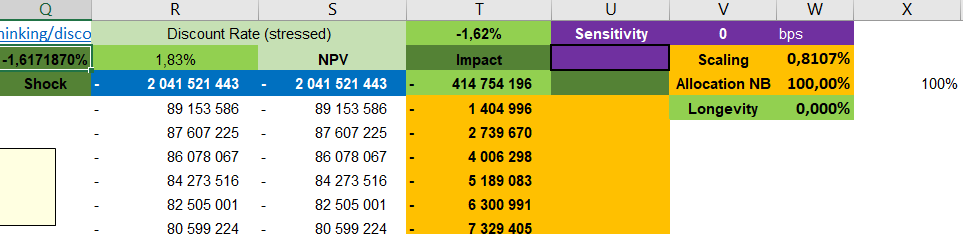

In [7]:
# stressed_rate formula = base_rate + shock_rate
base_rate = 0.0345
shock_rate = -0.01617187 # return rate_total_260d numa data
# other params
longevity_rate = 0
scaling = 0.00810678790839239
allocation_nb = 1
allocation_nb2 = 1

# results
df_discount_results, sum_npv_base_rate, sum_npv_stressed_discount_rate, sum_impact = simulate_npv_impact_by_stressed_discount_rate(df_aux, 'Ano', 'resp_b_NB_total',
                                              base_rate,
                                              shock_rate,
                                              scaling,
                                              allocation_nb,
                                              allocation_nb2,
                                              longevity_rate)

In [8]:
print(f"Soma dos NPVs com desconto a {base_rate*100}%: {sum_npv_base_rate}\n")
print(f"Soma dos NPVs com desconto a {round((base_rate+shock_rate)*100,2)}%: {sum_npv_stressed_discount_rate}\n")
print(f"Soma dos impactos do stress nas taxas de desconto: {sum_impact}\n")

Soma dos NPVs com desconto a 3.45%: 1630102533

Soma dos NPVs com desconto a 1.83%: 2041521443

Soma dos impactos do stress nas taxas de desconto: 414754196



In [9]:
df_discount_results.head()
df_resp_descontadas.head()

,Ano,resp_b_NB_total,ano_aux,resp_d
0,2024,90787605,1,87759889
1,2025,90848008,2,84889586
2,2026,90898293,3,82103986
3,2027,90623760,4,79126161
4,2028,90348091,5,76254680


# Extração longevidade e cálculo da longevity rate <a name='longevity'></a>

https://ec.europa.eu/eurostat/databrowser/view/demo_mlexpec__custom_12856226/default/table?lang=en

In [10]:
pd.set_option('display.float_format', None)

start_year = 1999

longevity = obi.extract_life_expectancy_by_year(65,'PT', 'T', start_year)[['Ano', 'Esperança média de vida aos 65 anos (T)']]
longevity['abs_diff(T)'] = longevity['Esperança média de vida aos 65 anos (T)'].diff()
longevity = longevity[longevity['Ano'] > start_year]
longevity

,Ano,Esperança média de vida aos 65 anos (T),abs_diff(T)
10,2000,17.4,0.4
11,2001,17.7,0.3
12,2002,17.7,0.0
13,2003,17.6,-0.1
14,2004,18.3,0.7
15,2005,18.0,-0.3
16,2006,18.7,0.7
17,2007,18.8,0.1
18,2008,18.9,0.1
19,2009,19.2,0.3


In [11]:
df_aux_longevity = df_aux.copy()

current_year = 2022
# esperança média de vida (considerando a coluna de ambos os géneros) no current year
exp_life = longevity.loc[longevity['Ano'] == current_year, 'Esperança média de vida aos 65 anos (T)'].values[0]

# soma das responsabilidades (NB sem BES + NBA) brutas nao descontadas
resp_b_nb_total = df_aux_longevity['resp_b_NB_total'].sum()
# maior aumento de um ano para o outro da esp vida (considerando a coluna de ambos os géneros)
maior_aumento = longevity['abs_diff(T)'].max()

# cálculo da longevity
longevity_rate = maior_aumento/exp_life

# não sei para que é este valor
E1 = sum(df_aux_longevity['resp_b_NB_total']*(1 + longevity_rate) - df_aux_longevity['resp_b_NBA'])

print(f'Esperança média de vida aos 65 anos no ano {current_year}: {exp_life}\n' )
print(f'Responsabilidades brutas (NB sem BES + NBA): {int(resp_b_nb_total.round())}\n')
print(f'Nos últimos 20 anos o maior aumeno de um ano para o outro na esperança média de vida é: {maior_aumento}\n')
print(f'Longevity rate: {longevity_rate}\n')
print(E1)

Esperança média de vida aos 65 anos no ano 2022: 20.5

Responsabilidades brutas (NB sem BES + NBA): 2741307556

Nos últimos 20 anos o maior aumeno de um ano para o outro na esperança média de vida é: 0.6999999999999993

Longevity rate: 0.0341463414634146

2802963021.883929


# Load yields timeseries <a name='loadircs'></a>

In [12]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [13]:
df_ircs = pd.read_csv(path + 'Dados_high_level_assessment/ir_cs_str_daily_yields.csv')
df_ircs_aaa = pd.read_csv(path + 'Dados_high_level_assessment/ir_cs_aaa_daily_yields.csv')

In [14]:
df_ircs[df_ircs['Hist Date'] == '2015-01-16']

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2258,2015-01-16,0.484550,-1.422500,0.525080,-0.432670,1.009630,-1.855170


In [15]:
df_ircs[df_ircs['Hist Date'] == '2012-05-25']

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2935,2012-05-25,1.424000,-1.695000,1.709830,0.077810,3.133830,-1.617190


In [16]:
df_ircs[df_ircs['Hist Date'] == '2012-05-25']

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2935,2012-05-25,1.424000,-1.695000,1.709830,0.077810,3.133830,-1.617190


In [17]:
df_ircs[df_ircs['Return_total_260d'] == df_ircs['Return_total_260d'].min()]

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2266,2015-01-06,0.474500,-1.511250,0.590680,-0.411320,1.065180,-1.922570


In [18]:
df_ircs_aaa[df_ircs_aaa['Return_total_260d'] == df_ircs_aaa['Return_total_260d'].min()]

,Hist Date,CS_Rate,CS_Return_260d,IR_Rate,IR_Return_260d,Rate_total,Return_total_260d,Discount_rate
2222,2015-01-30,0.449560,-0.524530,0.696646,-2.001354,1.146206,-2.490134,-1.343927


In [19]:
df_ircs[df_ircs['IR_Return_260d'] == df_ircs['IR_Return_260d'].min()]

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2938,2012-05-22,1.405000,-1.725000,1.743910,0.115410,3.148910,-1.609590


In [20]:
df_ircs[df_ircs['IR_Return_260d'] < df_ircs['IR_Return_260d'].quantile(0.001)].sort_values('IR_Return_260d',ascending=False)

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2929,2012-06-04,1.349500,-1.691500,1.676750,0.000940,3.026250,-1.690560
2936,2012-05-24,1.375000,-1.691550,1.708420,0.037820,3.083420,-1.653730
2937,2012-05-23,1.394000,-1.694200,1.717960,0.069400,3.111960,-1.624800
2935,2012-05-25,1.424000,-1.695000,1.709830,0.077810,3.133830,-1.617190
2930,2012-06-01,1.353500,-1.722500,1.710490,0.058950,3.063990,-1.663550
2938,2012-05-22,1.405000,-1.725000,1.743910,0.115410,3.148910,-1.609590


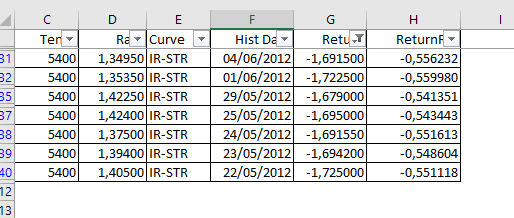

In [21]:
df_ircs[df_ircs['Hist Date'] == '2012-05-25']

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2935,2012-05-25,1.424000,-1.695000,1.709830,0.077810,3.133830,-1.617190


In [22]:
df_ircs_aaa[df_ircs_aaa['IR_Return_260d'] < df_ircs_aaa['IR_Return_260d'].quantile(0.001)].sort_values('IR_Return_260d', ascending=False)

,Hist Date,CS_Rate,CS_Return_260d,IR_Rate,IR_Return_260d,Rate_total,Return_total_260d,Discount_rate
2172,2015-04-16,0.783490,-0.173350,0.343825,-2.035128,1.127315,-2.153458,-1.026143
2168,2015-04-22,0.781080,-0.209760,0.394118,-2.048099,1.175198,-2.217759,-1.042560
2169,2015-04-21,0.785150,-0.189510,0.356281,-2.054448,1.141431,-2.230548,-1.089117
2171,2015-04-17,0.784260,-0.187480,0.326368,-2.055528,1.110628,-2.173758,-1.063131
2170,2015-04-20,0.791840,-0.178020,0.314273,-2.089790,1.106113,-2.205190,-1.099076


In [23]:
df_ircs['IR_Return_260d'].quantile(0.001)

-1.6808875

In [24]:
df_ircs[df_ircs['IR_Return_260d'] <= -1.6808875].sort_values(by='IR_Return_260d', ascending=False)

,Hist Date,IR_Rate,IR_Return_260d,CS_Rate,CS_Return_260d,Rate_total,Return_total_260d
2929,2012-06-04,1.349500,-1.691500,1.676750,0.000940,3.026250,-1.690560
2936,2012-05-24,1.375000,-1.691550,1.708420,0.037820,3.083420,-1.653730
2937,2012-05-23,1.394000,-1.694200,1.717960,0.069400,3.111960,-1.624800
2935,2012-05-25,1.424000,-1.695000,1.709830,0.077810,3.133830,-1.617190
2930,2012-06-01,1.353500,-1.722500,1.710490,0.058950,3.063990,-1.663550
2938,2012-05-22,1.405000,-1.725000,1.743910,0.115410,3.148910,-1.609590


In [25]:
df_ircs_aaa[df_ircs_aaa['IR_Return_260d'] <= df_ircs['IR_Return_260d'].quantile(0.001)].sort_values(by='IR_Return_260d', ascending=False)

,Hist Date,CS_Rate,CS_Return_260d,IR_Rate,IR_Return_260d,Rate_total,Return_total_260d,Discount_rate
2208,2015-02-19,0.470310,-0.501350,0.775375,-1.696527,1.245685,-2.194827,-0.949142
2237,2015-01-09,0.569940,-0.404650,1.003206,-1.702180,1.573146,-2.159670,-0.586525
2205,2015-02-24,0.435890,-0.525830,0.789646,-1.703383,1.225536,-2.225013,-0.999476
2209,2015-02-18,0.461610,-0.506730,0.763606,-1.704986,1.225216,-2.201396,-0.976180
2162,2015-04-30,0.774840,-0.171160,0.662278,-1.718179,1.437118,-1.917999,-0.480881
...,...,...,...,...,...,...,...,...
2172,2015-04-16,0.783490,-0.173350,0.343825,-2.035128,1.127315,-2.153458,-1.026143
2168,2015-04-22,0.781080,-0.209760,0.394118,-2.048099,1.175198,-2.217759,-1.042560
2169,2015-04-21,0.785150,-0.189510,0.356281,-2.054448,1.141431,-2.230548,-1.089117
2171,2015-04-17,0.784260,-0.187480,0.326368,-2.055528,1.110628,-2.173758,-1.063131


# Load Risk free and Credit Spread rates (Dados após 2016)

In [26]:
final_rates = pd.read_excel(path + 'Dados_high_level_assessment/riskfree_creditspread_rates.xlsx')
final_rates['diff_str_swap'] = final_rates['IR_STR_15y'] - final_rates['IR_SWAP_15y'] 
final_rates['diff_str_aaa'] = final_rates['IR_STR_15y'] - final_rates['IR_AAA_15Y'] 
final_rates

,Hist Date,IR_STR_15y,IR_SWAP_15y,CS_AA_15y,CS_AAA_15y,IR_AAA_15Y,diff_str_swap,diff_str_aaa
0,2023-12-29,2.462414,2.569173,0.906200,0.722986,2.300209,-0.106759,0.162205
1,2023-12-28,2.393649,2.496166,0.923600,0.705951,2.202767,-0.102517,0.190882
2,2023-12-27,2.341822,2.445034,0.917900,0.732978,2.177455,-0.103212,0.164367
3,2023-12-22,2.423275,2.532319,0.917900,0.711325,2.217449,-0.109044,0.205826
4,2023-12-21,2.399785,2.500389,0.946100,0.737715,2.216152,-0.100604,0.183633
...,...,...,...,...,...,...,...,...
1881,2016-05-24,0.644000,0.971142,0.858724,0.554300,0.610491,-0.327142,0.033509
1882,2016-05-23,0.637000,0.971317,0.861069,0.568200,0.615572,-0.334317,0.021428
1883,2016-05-20,0.615000,0.947060,0.880766,0.587000,0.613645,-0.332060,0.001355
1884,2016-05-19,0.623000,0.951419,0.873405,0.581300,0.591941,-0.328419,0.031059


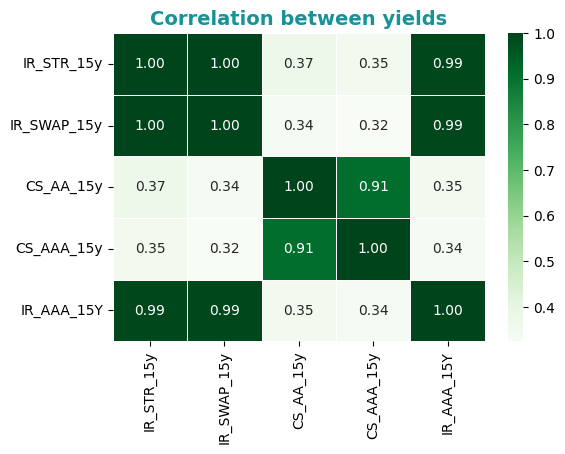

In [27]:
obi.plot_corr_matrix(final_rates.drop(columns=['Hist Date', 'diff_str_aaa', 'diff_str_swap']), title='Correlation between yields')

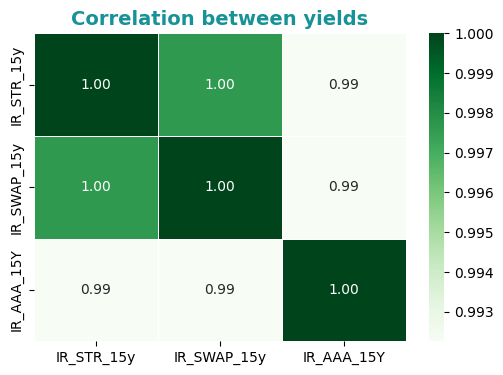

In [28]:
obi.plot_corr_matrix(final_rates.drop(columns=['Hist Date', 'CS_AA_15y', 'CS_AAA_15y', 'diff_str_aaa', 'diff_str_swap']), title='Correlation between yields')

## Load IRSTR, IRSWAP, IRAAA (dados após 2003)

In [29]:
final_rates_since2003 = pd.read_excel(path + 'Dados_high_level_assessment/rf_yields_since2003.xlsx')
final_rates_since2003

,Hist Date,IR_STR_15y,IR_SWAP_15y,IR_AAA_15Y,diff_str_swap,diff_str_aaa
0,2023-12-29,2.462414,2.569173,2.300209,-0.106759,0.162205
1,2023-12-28,2.393649,2.496166,2.202767,-0.102517,0.190882
2,2023-12-27,2.341822,2.445034,2.177455,-0.103212,0.164367
3,2023-12-26,2.422053,2.518967,NaN,-0.096914,NaN
4,2023-12-22,2.423275,2.532319,2.217449,-0.109044,0.205826
...,...,...,...,...,...,...
5232,2003-01-08,4.736880,4.914000,NaN,-0.177120,NaN
5233,2003-01-07,4.746640,5.009000,NaN,-0.262360,NaN
5234,2003-01-06,4.746640,5.051000,NaN,-0.304360,NaN
5235,2003-01-03,4.746640,5.050000,NaN,-0.303360,NaN


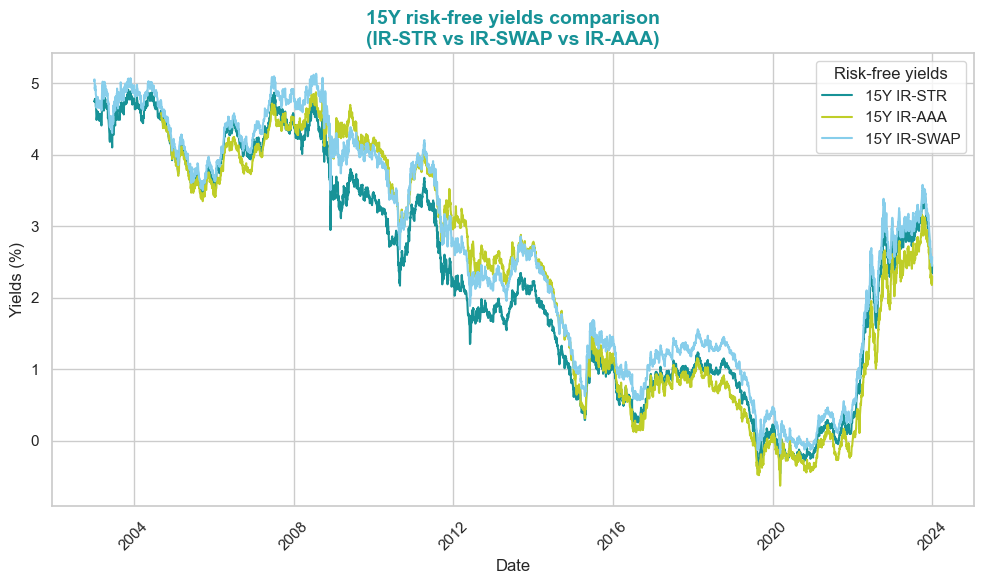

In [30]:
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=final_rates_since2003, 
    x='Hist Date', 
    y='IR_STR_15y', 
    label='15Y IR-STR', 
    linewidth=1.5,
    color=default_color2
)
sns.lineplot(
    data=final_rates_since2003, 
    x='Hist Date', 
    y='IR_AAA_15Y', 
    label='15Y IR-AAA', 
    linewidth=1.5,
    color=default_color
)

sns.lineplot(
    data=final_rates_since2003, 
    x='Hist Date', 
    y='IR_SWAP_15y', 
    label='15Y IR-SWAP', 
    linewidth=1.5,
    color='skyblue'
)


plt.title('15Y risk-free yields comparison\n(IR-STR vs IR-SWAP vs IR-AAA)', fontsize=14, fontweight='bold', color=default_color2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Yields (%)', fontsize=12)

plt.legend(title='Risk-free yields')
plt.xticks(rotation=45)
plt.tight_layout()

### Estatísticas yields e diferenças das yields

### Plot returns das taxas sem risco e ver quais são os dias extremos

**só há dados apos 2016 porque é quando há credit spreads**

IR BUSCAR DADOS DAS TAXAS SEM RISCO DESDE 2003 para ver estatisticas e calcular apenas returns de taxa sem risco e correpondentes dias "extremos"

In [31]:
final_rates.drop(columns=['Hist Date']).describe().iloc[1:]

,IR_STR_15y,IR_SWAP_15y,CS_AA_15y,CS_AAA_15y,IR_AAA_15Y,diff_str_swap,diff_str_aaa
mean,0.949433,1.184119,0.676680,0.604261,0.740826,-0.234686,0.209234
std,1.020452,1.003521,0.265577,0.207649,0.940554,0.071887,0.145489
min,-0.460300,-0.176798,0.112351,0.270600,-0.627865,-0.499840,-0.078462
25%,0.155125,0.345046,0.512228,0.468150,-0.027461,-0.302083,0.101865
50%,0.831000,1.113923,0.604996,0.539000,0.631536,-0.246535,0.181899
75%,1.113250,1.415763,0.853948,0.714668,0.992962,-0.170018,0.285835
max,3.497862,3.577806,1.847273,1.530900,3.158444,-0.040516,0.762377


In [32]:
final_rates_since2003.drop(columns=['Hist Date']).describe().iloc[1:]

,IR_STR_15y,IR_SWAP_15y,IR_AAA_15Y,diff_str_swap,diff_str_aaa
mean,2.326895,2.637089,2.239547,-0.319178,-0.121659
std,1.588174,1.593899,1.622665,0.163839,0.402393
min,-0.460300,-0.176798,-0.627865,-0.685800,-1.156884
25%,0.943000,1.256401,0.760772,-0.461495,-0.498828
50%,2.227000,2.666992,2.480374,-0.302383,0.042951
75%,3.772680,4.078000,3.803148,-0.176500,0.175528
max,4.910820,5.131200,4.872226,-0.005030,0.762377


In [33]:
final_rates_aux = final_rates_since2003[['Hist Date', 'IR_STR_15y', 'IR_SWAP_15y', 'IR_AAA_15Y']]
final_rates_aux['return_260d_str'] = final_rates_aux['IR_STR_15y'] - final_rates_aux['IR_STR_15y'].shift(-260)
final_rates_aux['return_260d_swap'] = final_rates_aux['IR_SWAP_15y'] - final_rates_aux['IR_SWAP_15y'].shift(-260)
final_rates_aux['return_260d_aaa'] = final_rates_aux['IR_AAA_15Y'] - final_rates_aux['IR_AAA_15Y'].shift(-260)
final_rates_aux

,Hist Date,IR_STR_15y,IR_SWAP_15y,IR_AAA_15Y,return_260d_str,return_260d_swap,return_260d_aaa
0,2023-12-29,2.462414,2.569173,2.300209,0.108177,0.016721,0.296565
1,2023-12-28,2.393649,2.496166,2.202767,0.031441,-0.064662,0.287424
2,2023-12-27,2.341822,2.445034,2.177455,0.005300,-0.091450,0.261012
3,2023-12-26,2.422053,2.518967,NaN,0.060772,-0.037407,NaN
4,2023-12-22,2.423275,2.532319,2.217449,0.118775,0.029768,0.383010
...,...,...,...,...,...,...,...
5232,2003-01-08,4.736880,4.914000,NaN,NaN,NaN,NaN
5233,2003-01-07,4.746640,5.009000,NaN,NaN,NaN,NaN
5234,2003-01-06,4.746640,5.051000,NaN,NaN,NaN,NaN
5235,2003-01-03,4.746640,5.050000,NaN,NaN,NaN,NaN


In [34]:
final_rates_aux[['return_260d_str', 'return_260d_swap', 'return_260d_aaa']].describe().iloc[1:]

,return_260d_str,return_260d_swap,return_260d_aaa
mean,-0.089492,-0.089897,-0.074684
std,0.789230,0.810964,0.775151
min,-1.999000,-1.987743,-2.096455
25%,-0.673000,-0.675425,-0.580190
50%,-0.061000,-0.059744,-0.077962
75%,0.301340,0.328456,0.301300
max,3.016068,3.048412,2.810579


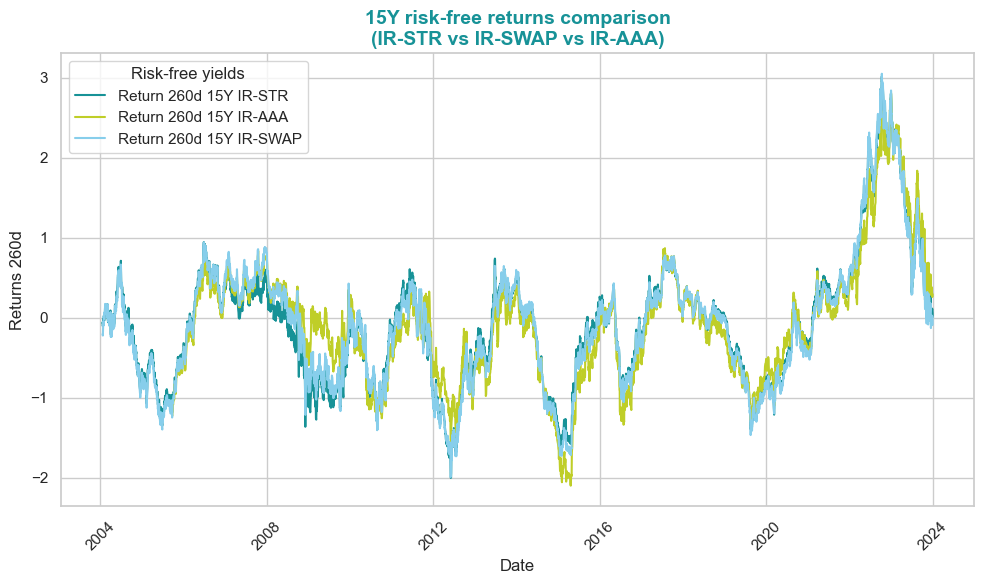

In [35]:
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=final_rates_aux, 
    x='Hist Date', 
    y='return_260d_str', 
    label='Return 260d 15Y IR-STR', 
    linewidth=1.5,
    color=default_color2
)
sns.lineplot(
    data=final_rates_aux, 
    x='Hist Date', 
    y='return_260d_aaa', 
    label='Return 260d 15Y IR-AAA', 
    linewidth=1.5,
    color=default_color
)

sns.lineplot(
    data=final_rates_aux, 
    x='Hist Date', 
    y='return_260d_swap', 
    label='Return 260d 15Y IR-SWAP', 
    linewidth=1.5,
    color='skyblue'
)


plt.title('15Y risk-free returns comparison\n(IR-STR vs IR-SWAP vs IR-AAA)', fontsize=14, fontweight='bold', color=default_color2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns 260d', fontsize=12)

plt.legend(title='Risk-free yields')
plt.xticks(rotation=45)
plt.tight_layout()

In [36]:
final_rates_aux[final_rates_aux['Hist Date'] == '2012-05-25']

,Hist Date,IR_STR_15y,IR_SWAP_15y,IR_AAA_15Y,return_260d_str,return_260d_swap,return_260d_aaa
2890,2012-05-25,1.626000,2.178055,2.484656,-1.729000,-1.668210,-1.288946


In [37]:
final_rates_aux[final_rates_aux['return_260d_str'] == final_rates_aux['return_260d_str'].min()]

,Hist Date,IR_STR_15y,IR_SWAP_15y,IR_AAA_15Y,return_260d_str,return_260d_swap,return_260d_aaa
2885,2012-06-01,1.352000,1.885576,2.188931,-1.999000,-1.987743,-1.558085


In [38]:
# linha do quantil 0.1
final_rates_auxv2 = final_rates_aux.sort_values('return_260d_str')
final_rates_auxv2[final_rates_auxv2['return_260d_str'] >= final_rates_auxv2['return_260d_str'].quantile(0.001)].iloc[0]

Hist Date           2012-06-06 00:00:00
IR_STR_15y                     1.495000
IR_SWAP_15y                    2.040571
IR_AAA_15Y                     2.351070
return_260d_str               -1.766000
return_260d_swap              -1.735987
return_260d_aaa               -1.363791
Name: 2882, dtype: object

# RESULTS VAR, IMPACTS <a name='var_results'></a>

In [39]:
longevity_rate = 0
scaling = 0.00810678790839239
allocation_nb = 1 
allocation_nb2 = 1
rate = 3.45 # na função este valor é dividido por 100

print('Usando dados da yield EUR-STR da BGG:')
results_str, var_999_str, var_99_str = compute_impacts_var(df_ircs, df_resp_descontadas, rate, longevity_rate, scaling, allocation_nb=1, allocation_nb2=1)
print()
print('Usando dados da yield AAA do BCE:')
results_aaa, var_999_aaa, var_99_aa = compute_impacts_var(df_ircs_aaa, df_resp_descontadas, rate, longevity_rate, scaling, allocation_nb=1, allocation_nb2=1)

Usando dados da yield EUR-STR da BGG:
O VaR_99.9 -486274093 e a data correspondente é: 2015-01-14
O VaR_min -511611541 e a data correspondente é: 2015-01-06

Usando dados da yield AAA do BCE:
O VaR_99.9 -697588645 e a data correspondente é: 2015-02-04
O VaR_min -711438728 e a data correspondente é: 2015-01-30


In [40]:
pd.set_option('display.float_format', '{:.3f}'.format)

display(
    results_aaa[results_aaa['Hist Date'] =='2015-02-04'],
    results_aaa[results_aaa['Hist Date'] =='2015-01-30'],
    results_aaa[results_aaa['Hist Date'] =='2012-05-25'] # dia com maior credit spread, ao drg aqui acho que dá 411 e depois fazem scaling que dá 414
       )

,Hist Date,Return_total_260d,stressed_rate,responsabilidades_diarias,impacto
2219,2015-02-04,-2.457,0.993,2323336264.461,-698853630.075


,Hist Date,Return_total_260d,stressed_rate,responsabilidades_diarias,impacto
2222,2015-01-30,-2.490,0.960,2335820158.503,-711438728.398


,Hist Date,Return_total_260d,stressed_rate,responsabilidades_diarias,impacto
2896,2012-05-25,-1.209,2.241,1923244107.363,-295518010.715


In [41]:
display(
    results_str[results_str['Hist Date'] =='2015-01-14'],
    results_str[results_str['Hist Date'] =='2015-01-06'],
    results_str[results_str['Hist Date'] =='2012-05-25'] # dia com maior credit spread, ao drg aqui acho que dá 411 e depois fazem scaling que dá 414
       )

,Hist Date,Return_total_260d,stressed_rate,responsabilidades_diarias,impacto
2260,2015-01-14,-1.845,1.605,2112608864.470,-486417907.745


,Hist Date,Return_total_260d,stressed_rate,responsabilidades_diarias,impacto
2266,2015-01-06,-1.923,1.527,2137599901.044,-511611541.353


,Hist Date,Return_total_260d,stressed_rate,responsabilidades_diarias,impacto
2935,2012-05-25,-1.617,1.833,2041522354.030,-414755114.043


In [42]:
results_str.to_excel(path + 'Dados_high_level_assessment/results_str.xlsx')

In [43]:
results_aaa.to_excel(path + 'Dados_high_level_assessment/results_aaa.xlsx')

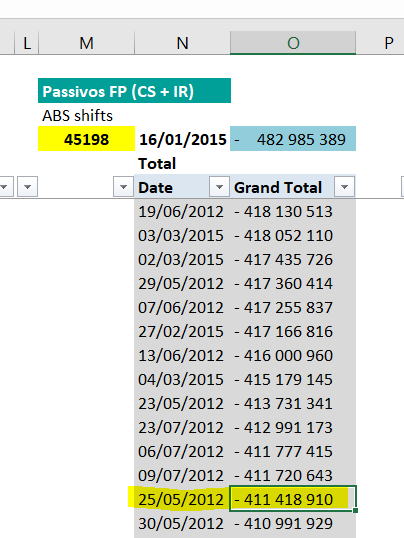

SHEET TOTAL DO FICHEIRO REPORTING ICAAP 2023

O 414M DO DRG ESTÁ NA SHEET SUMMARY DO REPORTING ICAAP NA CELULA E22

E22 = VALOR DO IMPACTO NESTA DATA 2012-05-25 + (VALOR "RESIDUAL COM SCALINGS DIFICEIS DE PERCEBER")

In [44]:
df_impactos_drg = pd.read_excel(
    'ResultadosFinaisAnaliseGVM.xlsx', 
    sheet_name='Passivos', 
    skiprows=5
)[['Date', 'Grand Total']].rename(columns={
    'Date': 'Hist Date',
    'Grand Total': 'Impacts DRG'    
})

df_impactos_drg['Hist Date'] = pd.to_datetime(df_impactos_drg['Hist Date'], errors='coerce')

df_impactos_gvm = results_str[['Hist Date', 'impacto']].rename(columns={'impacto': 'Impacts GVM'})
df_impactos_gvm['Hist Date'] = pd.to_datetime(df_impactos_gvm['Hist Date'], errors='coerce')

df_impactos_comp = df_impactos_drg.merge(df_impactos_gvm, on='Hist Date', how='left')
df_impactos_comp['diff'] = df_impactos_comp['Impacts DRG'] - df_impactos_comp['Impacts GVM']
df_impactos_comp

FileNotFoundError: [Errno 2] No such file or directory: 'ResultadosFinaisAnaliseGVM.xlsx'

In [ ]:
df_impactos_comp.to_excel('impactos_drg_gvm.xlsx', index=False)

In [ ]:
df_impactos_comp.drop(columns=['Hist Date']).describe().iloc[1:4]

In [ ]:
df_impactos_comp[df_impactos_comp['Hist Date'].isin(['2012-05-25', '2015-01-06'])]

In [ ]:
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_impactos_comp, 
    x='Hist Date', 
    y=df_impactos_comp['Impacts DRG'] / 1e6, 
    label='DRG Impacts', 
    linewidth=1.5,
    color=default_color2
)
sns.lineplot(
    data=df_impactos_comp, 
    x='Hist Date', 
    y=df_impactos_comp['Impacts GVM'] / 1e6, 
    label='GVM Impacts', 
    linewidth=1.5,
    color=default_color
)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Impact results - GVM vs DRG', fontsize=14, fontweight='bold', color=default_color2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Impacts (M€)', fontsize=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

#### Diferenças devido a arrendondamentos

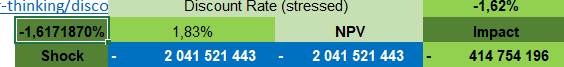

In [ ]:
results_str[results_str['Hist Date'] == '2012-05-25']

In [ ]:
results_str.dtypes

### Simulações

In [45]:
print('Não Usando stress de longevidade e usando dados da yield EUR-STR da BGG:')
compute_impacts_var(df_ircs, df_resp_descontadas, rate, longevity_rate, scaling, allocation_nb=1, allocation_nb2=1)

print()

print('Usando stress de longevidade (VALOR DRG) e usando dados da yield EUR-STR da BGG:')
compute_impacts_var(df_ircs, df_resp_descontadas, rate, 0.3/19.8, scaling, allocation_nb=1, allocation_nb2=1)

print()

print('Não Usando stress de longevidade e usando dados da yield AAA do BCE:')
compute_impacts_var(df_ircs_aaa, df_resp_descontadas, rate, longevity_rate, scaling, allocation_nb=1, allocation_nb2=1)

print()

print('Usando stress de longevidade (VALOR DRG) e usando dados da yield AAA do BCE:')
compute_impacts_var(df_ircs_aaa, df_resp_descontadas, rate, 0.3/19.8, scaling, allocation_nb=1, allocation_nb2=1)
print()

Não Usando stress de longevidade e usando dados da yield EUR-STR da BGG:
O VaR_99.9 -486274093 e a data correspondente é: 2015-01-14
O VaR_min -511611541 e a data correspondente é: 2015-01-06

Usando stress de longevidade (VALOR DRG) e usando dados da yield EUR-STR da BGG:
O VaR_99.9 -493641883 e a data correspondente é: 2015-01-14
O VaR_min -519363231 e a data correspondente é: 2015-01-06

Não Usando stress de longevidade e usando dados da yield AAA do BCE:
O VaR_99.9 -697588645 e a data correspondente é: 2015-02-04
O VaR_min -711438728 e a data correspondente é: 2015-01-30

Usando stress de longevidade (VALOR DRG) e usando dados da yield AAA do BCE:
O VaR_99.9 -708158170 e a data correspondente é: 2015-02-04
O VaR_min -722218103 e a data correspondente é: 2015-01-30



# Impactos com stress de IPC <a name='ipc_impacts'></a>

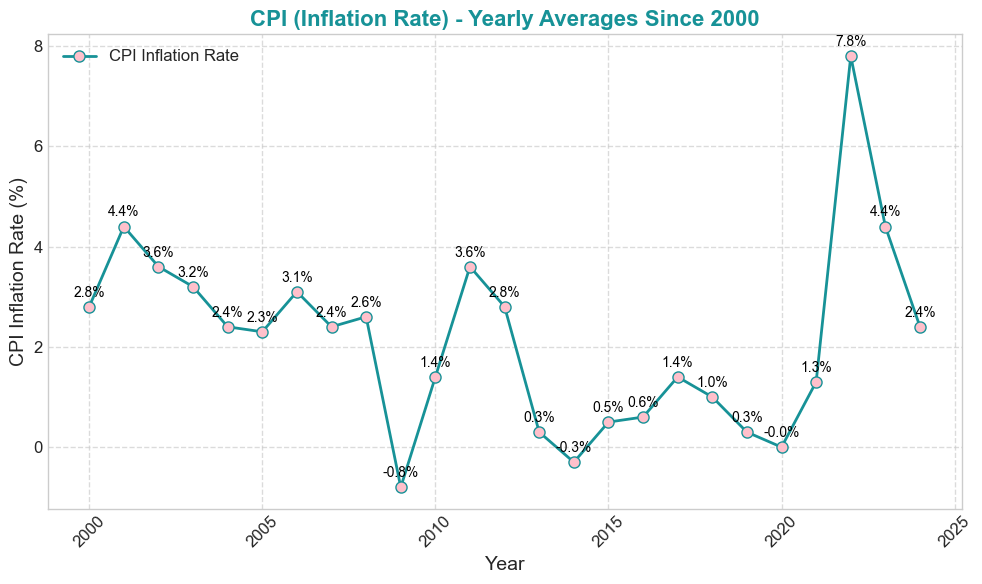

In [46]:
series_id = 5721524
variable_name = None

df_cpi = obi.extract_data_from_bank_pt(series_id, variable_name)
df_cpi = df_cpi[df_cpi['Date'] > '2000-01-01']

df_cpi['Year'] = df_cpi['Date'].dt.year

annual_cpi_avg = df_cpi.groupby('Year')['CPI (inflation rate)-year on year rate'].mean().reset_index().round(1)

plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10, 6))

plt.plot(annual_cpi_avg['Year'], 
         annual_cpi_avg['CPI (inflation rate)-year on year rate'], 
         marker='o', color=default_color2, linestyle='-', linewidth=2, markersize=8, markerfacecolor='pink', label='CPI Inflation Rate')

plt.title('CPI (Inflation Rate) - Yearly Averages Since 2000', fontsize=16, fontweight='bold', color=default_color2)
plt.xlabel('Year', fontsize=14)
plt.ylabel('CPI Inflation Rate (%)', fontsize=14)

for i, value in enumerate(annual_cpi_avg['CPI (inflation rate)-year on year rate']):
    plt.text(annual_cpi_avg['Year'][i], value + 0.2, f'{value:.1f}%', ha='center', fontsize=10, color='black')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


In [47]:
# parametros para a simulação
longevity_rate = maior_aumento/exp_life #na função de cálculo do NPV este valor é dividido por 100

display(rate, longevity_rate, scaling)

3.45

0.0341463414634146

0.00810678790839239

In [48]:
# resultados do VaR usando stress de IPC
df_stress_ipc, var_999_ipc, var_99_ipc = compute_impacts_var_with_inflation(df_ircs, df_resp_descontadas, rate, longevity_rate, scaling, allocation_nb=1, allocation_nb2=1)

O VaR_99.9 -542103104 e a data correspondente é: 2015-01-14
O VaR_min -570349538 e a data correspondente é: 2015-01-06


In [49]:
# CPI anual máximo dos últimos 20 anos, extraído do BP API STAT
cpi_rate = extract_max_annual_cpi(5721524, None)

print(f'CPI rate: {cpi_rate}') 
npv_ipc_stress = int(calculate_npv_with_inflation(df_aux, 0.01515,cpi_rate, 3.45))

print(f'NPV com stress de IPC: {npv_ipc_stress}')

CPI rate: 0.078
NPV com stress de IPC: 1783872876


# Experimentações <a name='exp'></a>

In [50]:
longevity_rate

0.0341463414634146

In [51]:
def calculate_npv_test(cashflows_df, longevity_rate, discount_rate):

    discount_rate = discount_rate/100
    
    cashflows_df['ano_aux'] = range(1, len(cashflows_df) + 1)

    cashflows_df['discounted_cashflow'] = (cashflows_df['resp_b_NB_total'] * (1 + longevity_rate)**cashflows_df['ano_aux'])/ (1 + discount_rate)**cashflows_df['ano_aux']
    sum_npv = cashflows_df['discounted_cashflow'].sum()

    return sum_npv

In [52]:
# diferença é o ano no expoente na formula
display(
    int(calculate_npv_test(df_aux, longevity_rate, 3.45)),
    int(calculate_npv(df_aux, longevity_rate, 3.45)),
    int(calculate_npv_test(df_aux, longevity_rate, 3.45)) - int(calculate_npv(df_aux, longevity_rate, 3.45))
       )
        

2725094752

1685764570

1039330182

In [53]:
display(
    int(calculate_npv_test(df_aux, 0, 3.45)),
    int(calculate_npv(df_aux, 0, 3.45)),
    int(calculate_npv_test(df_aux, 0, 3.45)) - int(calculate_npv(df_aux, 0, 3.45))
       )

1630102533

1630102533

0

In [54]:
display(
    int(calculate_npv_test(df_aux, 0.01515, 3.45)),
    int(calculate_npv(df_aux, 0.01515, 3.45)),
    int(calculate_npv_test(df_aux, 0.01515, 3.45)) - int(calculate_npv(df_aux, 0.01515, 3.45))
       )

2019458841

1654798586

364660255

### IDEIA DE FÓRMULA

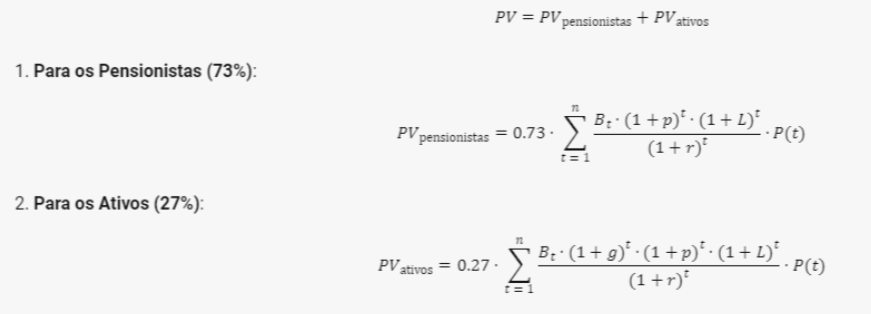

$$
t = \text{ano\_aux}
$$

$$
L = \text{longevity\_rate}
$$

$$
p = \text{taxa\_de\_crescimento\_de\_pensões}
$$

$$
g = \text{taxa\_de\_crescimento\_salarial}
$$

$$
B_{t} = \text{cashflow ano } t
$$
